In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

import numpy as np
import time

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from collections import defaultdict


from pypf.tree import PfTree
from pypf._utils import print_tree

from pypf.sliding_distance import matches, min_distance
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def transform_shape(s, x, i, theta):
    x_match = x[i:(i + s.shape[0])]
    v = x_match - s
    norm_v = np.linalg.norm(v)
    if norm_v == 0:
        return s
    else:
        return s - v / norm_v * theta

In [525]:
import numpy as np
from pypf.tree import PfTree
from sklearn.ensemble import BaggingClassifier

train = np.loadtxt("InsectWingbeatSound_TRAIN", delimiter=",")
x = train[:, 1:]
y = train[:, 0]

test = np.loadtxt("InsectWingbeatSound_TEST", delimiter=",")
x_test = test[:, 1:]
y_test = test[:, 0]
print(x.shape)

(220, 256)


In [526]:
tmp = defaultdict(list)
for i, label in enumerate(y):
    tmp[label].append(i)

label_index = {label:np.array(arr) for label, arr in tmp.items()}

In [527]:
tree = PfTree(n_shapelets=50, scale=True)
bag = BaggingClassifier(base_estimator=tree, random_state=10, n_estimators=100, n_jobs=8)
bag.fit(x, y)

BaggingClassifier(base_estimator=PfTree(max_depth=2147483648, min_samples_leaf=2, n_shapelets=50,
    random_state=<mtrand.RandomState object at 0x7fad6f543b40>, scale=True),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=8, oob_score=False,
         random_state=10, verbose=0, warm_start=False)

In [528]:
bag.score(x_test, y_test)

0.6323232323232323

In [529]:
def extract_paths(node, d, classes_, path):
    if node.is_leaf:
        d[classes_[np.argmax(node.proba)]].append(path)
    else:
        left_path = path.copy()
        left_path.append(("<=", node.shapelet.array, node.threshold))
        extract_paths(node.left, d, classes_, left_path)
        
        right_path = path.copy()
        right_path.append((">", node.shapelet.array, node.threshold))
        extract_paths(node.right, d, classes_, right_path)


In [530]:
paths = defaultdict(list)
for base_estimator in bag.estimators_:
    extract_paths(base_estimator.root_node_, paths, bag.classes_, [])

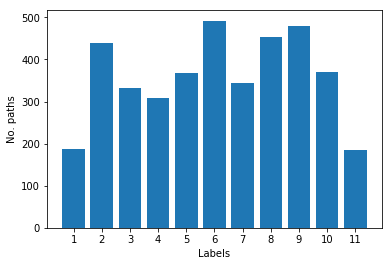

In [531]:
label, p_count = zip(*[(label, len(path)) for label, path in paths.items()])
plt.bar(label, p_count)
plt.xlabel("Labels")
plt.xticks(label)
plt.ylabel("No. paths")
plt.show()

In [532]:
def transform_with_path(x, path, epsilon=0.05):
    steps = []
    for direction, shapelet, threshold in path:
        if direction == "<=":
            distance, location = min_distance(shapelet, x, return_index=True)
            if distance > threshold:
                impute_shape = transform_shape(shapelet, x, location, threshold - epsilon)
                x[location:(location+len(shapelet))] = impute_shape
                steps.append(x.copy())
        else:
            locations = matches(shapelet, x, threshold)
            if len(locations) > 0:
                for location in locations:
                    impute_shape = transform_shape(shapelet, x, location, threshold + epsilon)
                    x[location:(location + len(shapelet))] = impute_shape
                    steps.append(x.copy())
    return x, steps

Convert 218 from 1.0 to 5


FloatProgress(value=0.0, max=367.0)

Path 91 has lowest cost: 16.687872344422917


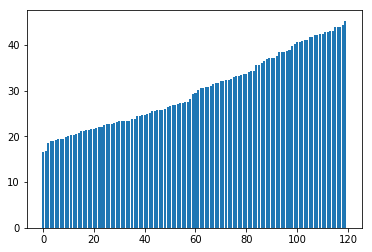

In [545]:
to_label = 5
from_label = 1
example = label_index[from_label][-1]
x_i = x[example, :]
min_cost = np.inf
min_i = -1
x_prime = None
print("Convert", example, "from", y[example], "to", to_label)
path_list = paths[to_label]

f = FloatProgress(min=0, max=len(path_list))
display(f)
x_prime = np.empty([len(path_list), x.shape[1]])
step_prime = np.empty(len(path_list), dtype=object)
for i, path in enumerate(path_list):
    x_i_prime, steps = transform_with_path(x_i.copy(), path, epsilon=0.05)
    x_prime[i, :] = x_i_prime
    step_prime[i] = steps
    f.value = i

y_prime = bag.predict(x_prime)
x_prime = x_prime[y_prime == to_label]
step_prime = step_prime[y_prime == to_label]
cost = np.linalg.norm(x_prime - x_i, axis=1) 
min_cost_i = np.argmin(cost)
min_x = x_prime[min_cost_i, :]
min_cost = cost[min_cost_i]
if min_cost_i >= 0:
    print("Path", min_cost_i, "has lowest cost:", min_cost )
    plt.bar(np.arange(cost.shape[0]), np.sort(cost))
else:
    print("No possible transformation")

In [546]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(1)
neigh.fit(x[y == to_label])
closest = neigh.kneighbors(min_x.reshape(1, -1), return_distance=False)

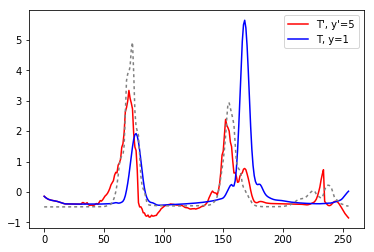

In [547]:
plt.figure()
plt.plot(min_x, c="red", label="T', y'={}".format(to_label))
plt.plot(x_i, c="blue", label="T, y={}".format(from_label))
for i in range(closest.shape[1]):
    plt.plot(x[y == to_label][closest[0, i]], c="gray", dashes=[2, 2])
plt.legend()

In [548]:
cost_sort = np.argsort(cost)

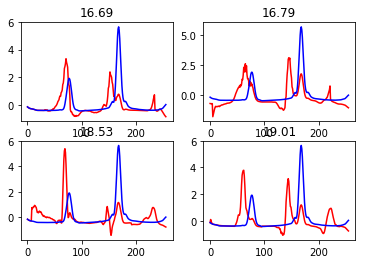

In [549]:
fig, ax = plt.subplots(2, 2)
for i, a in enumerate(ax.reshape(-1)):
    a.plot(x_prime[cost_sort[i], :], c="red")
    a.plot(x_i, c="blue")
    a.set_title("{:.2f}".format(cost[cost_sort[i]]))

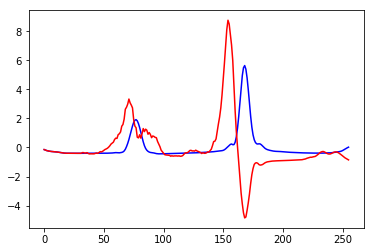

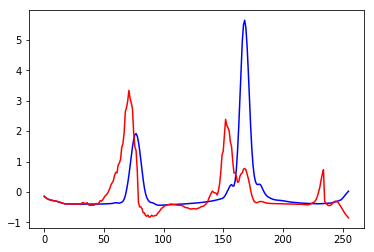

In [550]:
steps = step_prime[cost_sort[0]]
for step in steps:
    plt.figure()
    plt.plot(x_i, c="blue")
    plt.plot(step, c="red")